В этом блокноте я создам генеративную состязательную сеть (GAN), чтобы проиллюстрировать работу генеративной состязательной сети и сгенерировать изображения. Генеративное моделирование - это неконтролируемая обучающая задача в машинном обучении, которая включает автоматическое обнаружение и изучение закономерностей или паттернов во входных данных. Поскольку GANS работают, выявляя закономерности в данных, я буду использовать портреты, написанные маслом. Однако просмотр набора данных дает мне представление о том, что это будет долгий путь. Ориентация и позы в наборе данных сильно различаются. Помня об этом, я все еще готов попробовать. Только потому, что портреты - мое хобби. В принципе, я люблю портреты, написанные маслом.

In [1]:
#Importing Libraries
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
#Settings
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

Для этого проекта я использую файлы изображений портретов в формате .jpg. Набор данных включает в себя различных исполнителей. Я загружаю данные в виде TensorFlow.Набор данных,, с размером пакета 64. Я уменьшил размер изображения до (64,64), предполагая, что это будет менее обременительно с точки зрения вычислений для графического процессора.

In [17]:
cd D:\1

D:\1


In [18]:
ls -l

 ��� � ���ன�⢥ D �� ����� ��⪨.
 ��਩�� ����� ⮬�: E6AC-87D0

 ����ন��� ����� D:\1



���� �� ������


In [124]:
data

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = os.listdir(data_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

# Путь к каталогу с данными
data_path = "D:\\1"

# Трансформации для предобработки изображений
transform = transforms.Compose([
    transforms.Resize((72, 72)),    # изменяем размер изображений до 64x64
    transforms.ToTensor()           # преобразуем изображения в тензоры
])

# Создаем датасет изображений без меток
data = CustomImageDataset(data_path, transform=transform)

# Создаем DataLoader для управления загрузкой данных в партиях
batch_s = 64
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_s, shuffle=True)

# Пример использования DataLoader:


In [8]:
data_loader

In [9]:
data

Теперь, когда у меня загружен набор данных, давайте взглянем на несколько изображений.

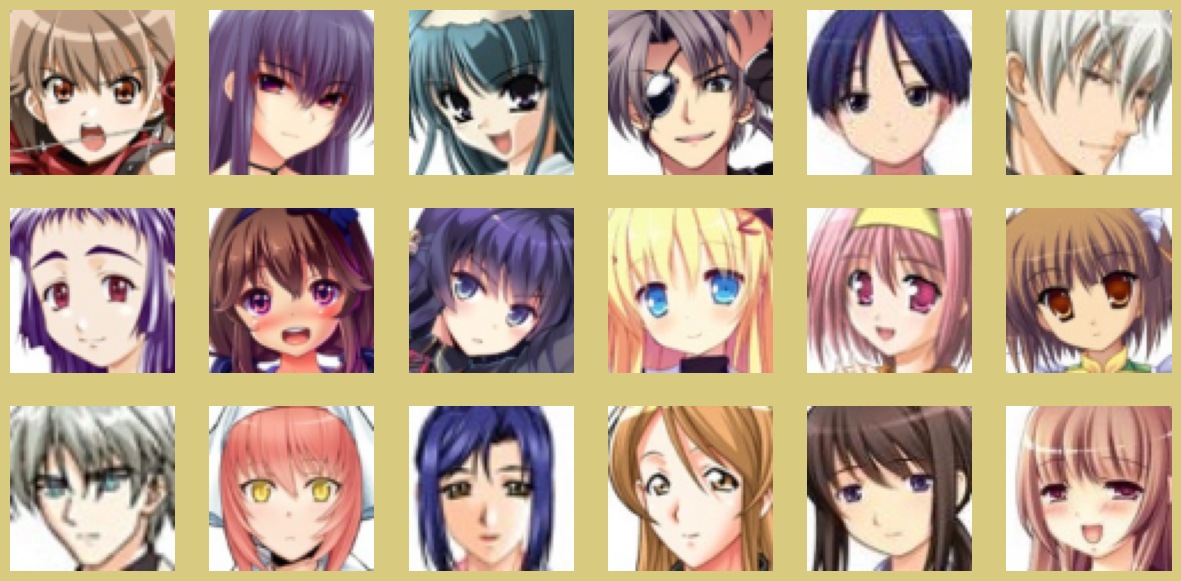

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def Show_Img(data):
    plt.figure(figsize=(15, 15))
    for images in data:
        for i in range(len(images)):
            ax = plt.subplot(6, 6, i + 1)
            # Переводим значения тензора в диапазон от 0 до 1
            img = images[i].numpy().transpose((1, 2, 0))  # Перестановка осей для правильного отображения
            img = (img - img.min()) / (img.max() - img.min())  # Нормализация значений
            ax.imshow(img)
            ax.axis("off")
            if i == 17:  # Остановить вывод после 18 изображений
                break
        break  # Остановить вывод после первой партии изображений
    plt.show()

# Отображение изображений из датасета
Show_Img(data_loader)



In [4]:
from torchvision import transforms

# Трансформация для нормализации данных
# Параметры mean и std соответствуют среднему и стандартному отклонению для каналов RGB
# Вы можете изменить их на свои значения в зависимости от вашего набора данных
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

# Применяем нормализацию к данным
# Предполагается, что ваш data_loader уже загружает данные изображений в диапазоне [0, 1]
# Если данные не находятся в этом диапазоне, сначала их нужно привести к нему
data_loader.dataset.transform = transforms.Compose([
    transforms.Resize((72, 72)),
    transforms.ToTensor(),
    normalize  # Применяем нормализацию
])

In [47]:
import torch
import torch.nn as nn

latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 4*4*256),
            nn.ReLU(inplace=True),
            # Преобразование в тензор размерности (256, 4, 4)
            nn.Unflatten(1, (256, 4, 4)),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=9, mode='nearest'),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Создание экземпляра генератора
generator = Generator()

# Вывод информации о модели
print(generator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(256, 4, 4))
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Upsample(scale_factor=9.0, mode='nearest')
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Upsample(scale_factor=2.0, mode='nearest')
    (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.

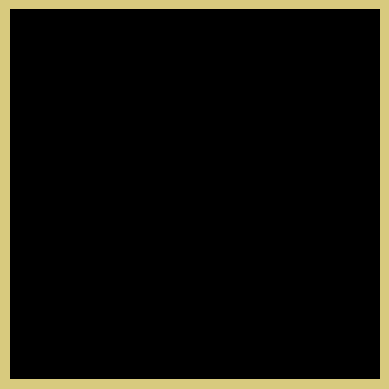

In [62]:
import matplotlib.pyplot as plt

# Создание случайного вектора seed
seed=torch.randn(1, latent_dim)
Generated_Portrait = generator(seed)
# Отключение градиентов и преобразование в массив numpy
image_np = Generated_Portrait.detach().numpy()
# Вывод изображения
plt.imshow(image_np[0].transpose(1, 2, 0))  # Переворачиваем размерности для корректного отображения
plt.axis("off")
plt.show()


In [7]:
image_np.shape

(1, 3, 72, 72)

In [52]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            nn.Flatten(),
            nn.Linear(512*3*3, 1)  # Последний полносвязный слой с одним выходным нейроном
        )

    def forward(self, x):
        return self.main(x)

# Создание экземпляра дискриминатора
discriminator = Discriminator()

# Вывод информации о модели
print(discriminator)



Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ZeroPad2d((0, 1, 0, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2, inplace=True)
    (15): Dropout(p=0.

In [58]:
batch_size = 1
latent_vectors = torch.randn(batch_size, latent_dim)

# Генерируем изображения с помощью генератора
generated_images = generator(latent_vectors)

# Оцениваем сгенерированные изображения с помощью дискриминатора
discriminator_verdict = discriminator(generated_images)

# Выводим результат оценки
print(discriminator_verdict)

discriminator_verdict_normalized = torch.sigmoid(discriminator_verdict)
print(discriminator_verdict_normalized)


tensor([[0.4394]], grad_fn=<AddmmBackward0>)
tensor([[0.6081]], grad_fn=<SigmoidBackward0>)


In [118]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = os.listdir(data_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

# Путь к каталогу с данными
data_path = "D:\\1"

# Трансформации для предобработки изображений
transform = transforms.Compose([
    transforms.Resize((64, 64)),    # изменяем размер изображений до 64x64
    transforms.ToTensor()           # преобразуем изображения в тензоры
])

# Создаем датасет изображений без меток
data = CustomImageDataset(data_path, transform=transform)

# Проверка размеров изображений после преобразований
sample_image = data[0]
print("Размер преобразованного изображения:", sample_image.shape)

# Проверка преобразования изображений в тензоры
print("Тип данных преобразованного изображения:", sample_image.dtype)

# Проверка размера батча при загрузке данных
batch_size = 64
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
print("Размер батча при загрузке данных:", batch_size)


Размер преобразованного изображения: torch.Size([3, 64, 64])
Тип данных преобразованного изображения: torch.float32
Размер батча при загрузке данных: 64


Выходные данные дискриминатора, то есть Вердикт, говорят о том, что существует почти пятьдесят на пятьдесят вероятность того, что изображение является реальным. Это происходит потому, что распознаватель еще не обучен. Таким образом, по сути, неподготовленный генератор сгенерировал некоторый пиксельный шум, а неподготовленный дискриминатор классифицировал его как "не могу определить". Пока что мы на правильном пути.

Давайте продолжим и построим архитектуру GAN для обучения.


КОМПИЛЯЦИЯ GAN

Тренинг GAN состоит из двух разделов:

Раздел 1: Распознаватель обучается во время простоя генератора. Дискриминатор - это обученные реальные изображения и случайный шум (от неподготовленного генератора). Это тренирует его отличать подделку от реальности. Это позволяет дискриминатору распознавать подделки.

Раздел 2: Генератор обучается, пока дискриминатор находится в режиме ожидания. В этом разделе проводится обучение генератора. После обучения дискриминатора на этом шаге используются предсказания, полученные от дискриминатора. Предоставляет генератору возможность корректировать веса, чтобы попытаться обмануть дискриминатор.

Описанный выше метод повторяется в течение нескольких эпох.

Следующий раздел определяет обучение GAN

In [59]:
import torch.nn.functional as F



class GAN(nn.Module):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.loss_fn = nn.BCELoss()
        # Инициализация оптимизаторов
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # Очистка метрик перед началом обучения
        self.d_loss_metric = []
        self.g_loss_metric = []

        # Sample random points in the latent space
        batch_size = real_images.size(0)
        seed = torch.randn(batch_size, self.latent_dim, device=real_images.device)
        
        generated_images = self.generator(seed)
        print("Минимальное значение generated_images:", generated_images.min().item())
        print("Максимальное значение generated_images:", generated_images.max().item())
       
        real_images = torch.sigmoid(real_images.repeat(1, 1, 9, 9)) # Повторить тензор 64 раза, не знаю почему но этот костыль помог
        real_images = F.interpolate(real_images, size=(72, 72), mode='nearest')
        print("Минимальное значение real_images:", real_images.min().item())
        print("Максимальное значение real_images:", real_images.max().item())
        
        combined_images = torch.cat([generated_images, real_images], dim=0)
        print("Минимальное значение combined_images:", combined_images.min().item())
        print("Максимальное значение combined_images:", combined_images.max().item())
        
        labels = torch.sigmoid(torch.cat([torch.ones((batch_size, 1), device=real_images.device),
                            torch.zeros((batch_size, 1), device=real_images.device)], dim=0))

       
        labels += 0.05 * torch.rand(labels.size(), device=real_images.device)
        print("Минимальное значение labels:", labels.min().item())
        print("Максимальное значение labels:",labels.max().item())
        # Train the discriminator
        self.d_optimizer.zero_grad()
        predictions = self.discriminator(combined_images)
        print("Минимальное значение predictions:", predictions.min().item())
        print("Максимальное значение predictions:", predictions.max().item())
        predictions = torch.sigmoid(predictions)
        
        d_loss = self.loss_fn(labels, predictions)
        d_loss.backward()
        self.d_optimizer.step()
        self.d_loss_metric.append(d_loss.item())

        # Sample random points in the latent space
        seed = torch.randn(batch_size, self.latent_dim, device=real_images.device)

        # Assemble labels that say "all real images"
        misleading_labels = torch.zeros((batch_size, 1), device=real_images.device)

        # Train the generator
        self.g_optimizer.zero_grad()
        generated_images = self.generator(seed)
        
        # Обратное преобразование нормализации
        generated_images = (generated_images + 1) / 2
        
        predictions = self.discriminator(generated_images)
        
        # Применяем сигмоиду к выводу дискриминатора
        predictions = torch.sigmoid(predictions)
        
        g_loss = self.loss_fn(misleading_labels, predictions)
        g_loss.backward()
        self.g_optimizer.step()
        self.g_loss_metric.append(g_loss.item())

        return {"d_loss": sum(self.d_loss_metric) / len(self.d_loss_metric), 
                "g_loss": sum(self.g_loss_metric) / len(self.g_loss_metric)}



In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Определение числа эпох
epochs = 20

# Оптимизаторы для генератора и дискриминатора
discriminator_opt = optim.Adam(discriminator.parameters(), lr=1.5e-4, betas=(0.5, 0.999))
generator_opt = optim.Adam(generator.parameters(), lr=1.5e-4, betas=(0.5, 0.999))

# Функция потерь для бинарной кросс-энтропии
loss_fn = nn.BCELoss()

# Определение GAN модели
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
# Смена порядка измерений в real_images


# Обучение GAN модели
for epoch in range(epochs):
    for real_images in data_loader:
        # Сброс градиентов для обоих оптимизаторов
        discriminator_opt.zero_grad()
        generator_opt.zero_grad()

        # Передача данных через модель GAN
        metrics = model.train_step(real_images)

        # Распространение градиентов и обновление параметров
        discriminator_opt.step()
        generator_opt.step()

    # Вывод прогресса после каждой эпохи
    print(f"Эпоха {epoch + 1}/{epochs}, d_loss: {metrics['d_loss']}, g_loss: {metrics['g_loss']}")


Минимальное значение generated_images: nan
Максимальное значение generated_images: nan
Минимальное значение real_images: 0.2689414322376251
Максимальное значение real_images: 0.7310585975646973
Минимальное значение combined_images: nan
Максимальное значение combined_images: nan
Минимальное значение labels: 0.5028087496757507
Максимальное значение labels: 0.779911994934082
Минимальное значение predictions: nan
Максимальное значение predictions: nan


RuntimeError: all elements of target should be between 0 and 1

In [198]:

def sample_noise(batch_size, latent_dim):
    return torch.randn(batch_size, latent_dim)
generated_images = generator(sample_noise(batch_size, latent_dim))
print("Диапазон входного тензора из генератора:")
print("Минимальное значение:", generated_images.min().item())
print("Максимальное значение:", generated_images.max().item())

# Проверка диапазона входного тензора из изображений
real_images = next(iter(data_loader))

print("\nДиапазон входного тензора из изображений:")
print("Минимальное значение:", real_images.min().item())
print("Максимальное значение:", real_images.max().item())


Диапазон входного тензора из генератора:
Минимальное значение: -0.9616230726242065
Максимальное значение: 0.9251499772071838

Диапазон входного тензора из изображений:
Минимальное значение: 0.0
Максимальное значение: 1.0


In [202]:
original_min = real_images.min().item()
original_max = real_images.max().item()
generated_images_denormalized = generated_images * (original_max - original_min) + original_min
generated_images_denormalized = (generated_images + 1) / 2
print("Диапазон входного тензора из генератора (до нормализации):")
print("Минимальное значение:", generated_images_denormalized.min().item())
print("Максимальное значение:", generated_images_denormalized.max().item())


Диапазон входного тензора из генератора (до нормализации):
Минимальное значение: 0.01918846368789673
Максимальное значение: 0.9625749588012695


In [210]:
print("\nДиапазон входного тензора из генератора:")
print("Минимальное значение:", generated_images.min().item())
print("Максимальное значение:", generated_images.max().item())

# Нормализация входного тензора из генератора
normalized_generated_images = (generated_images + 1) / 2

# Проверка диапазона после нормализации
print("\nДиапазон после нормализации:")
print("Минимальное значение:", normalized_generated_images.min().item())
print("Максимальное значение:", normalized_generated_images.max().item())


Диапазон входного тензора из генератора:
Минимальное значение: -0.9616230726242065
Максимальное значение: 0.9251499772071838

Диапазон после нормализации:
Минимальное значение: 0.01918846368789673
Максимальное значение: 0.9625749588012695


In [211]:
print(generated_images.shape)
print(real_images.shape)
print(real_images.shape)


torch.Size([64, 3, 72, 72])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
